In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [10]:
#Import date time and inspect
import datetime as dt
from sqlalchemy import inspect

#Explore database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("1 year ago date: ", year_ago_date)

# Perform a query to retrieve the data and precipitation scores
yearly_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago_date).all()
yearly_prcp

1 year ago date:  2016-08-23


[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [34]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(yearly_prcp, columns = ['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)

#Drop rows with null values
prcp_df = prcp_df.dropna()
#print("Column names:", prcp_df.columns)

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

#Converting the Date column to datetime format
prcp_df.index = pd.to_datetime(prcp_df.index)

#Convert the Date(index) for plotting the data
prcp_df.index = prcp_df.index.strftime('%Y-%m-%d')

print(prcp_df.head())


Column names: Index(['Precipitation'], dtype='object')
            Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.02
2016-08-23           0.05
2016-08-23           0.70
2016-08-23           0.15


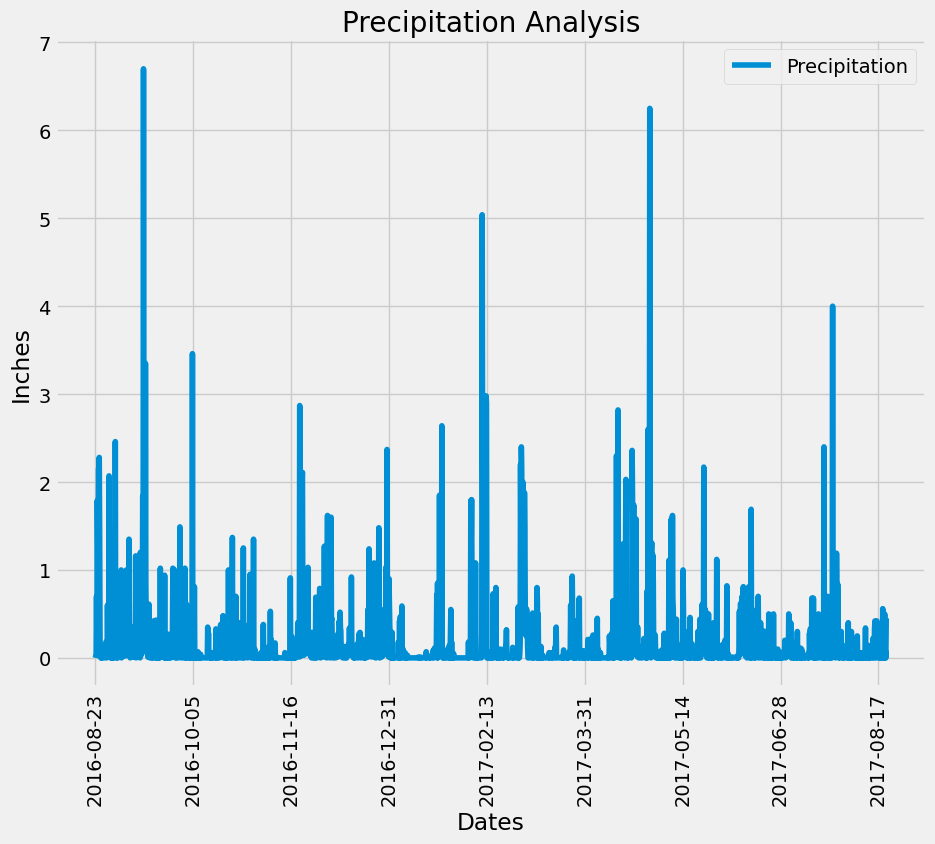

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(10,8), title = "Precipitation Analysis", rot=90)
plt.ylabel("Inches")
plt.xlabel("Dates")
plt.legend(loc='best')
plt.show()

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = prcp_df['Precipitation'].describe()
print(summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.id)).all()

[(9,)]

In [55]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count()).group_by(measurement.station).order_by(func.count().desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).first()

(54.0, 85.0, 71.66378066378067)

In [66]:
from sqlalchemy import and_
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
yearly_temp_obs = (session.query(measurement.date, measurement.tobs)
    .filter(and_(measurement.date >= year_ago_date, measurement.station == most_active_station))
    .order_by(measurement.date).all()
)
#yearly_temp_obs

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [67]:
#Convert the data into a Dataframe
temp_df = pd.DataFrame(yearly_temp_obs).set_index('date')
temp_df

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


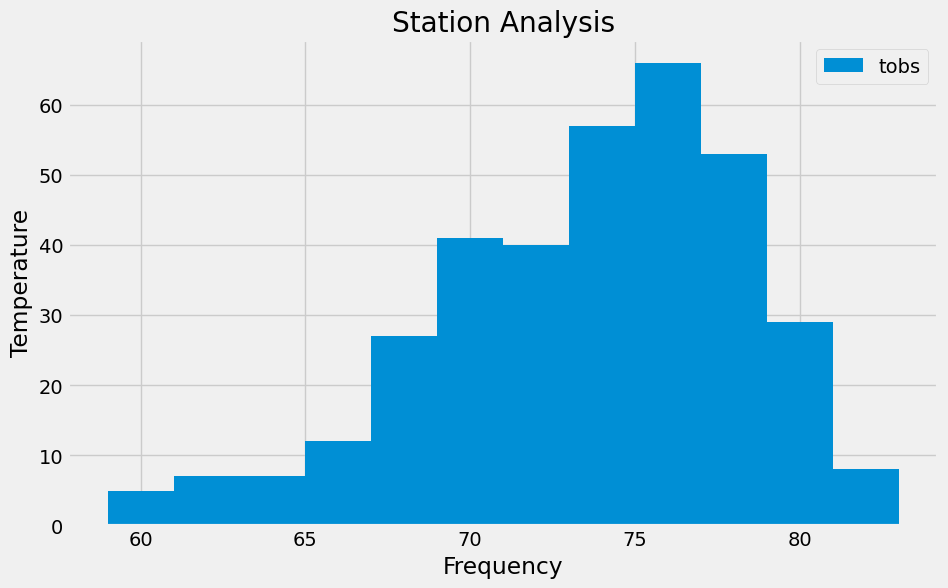

In [70]:
#plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temp_df, bins=12)
plt.ylabel("Temperature")
plt.xlabel("Frequency")
plt.title("Station Analysis")
plt.legend(['tobs'])
plt.show()

# Close Session

In [71]:
# Close Session
session.close()